# Calibration

Calibration is a procedure to determine parameter values of a quantitative model so that the model replicates key empirical regularities.  

In our model, the parameter values to be set include:

- the discount factor $\beta$
- the utility weight on consumption $\omega$
- the capital share $\alpha$
- the depreciation rate $\delta$
- the income replacement rate $\theta$


---

## How?

Some parameters are taken directly from data or estimated outside the model.  
For example:
- The capital share $\alpha$ and depreciation rate $\delta$ are often obtained from national accounts data.
- If the model includes a stochastic income process, its parameters are usually estimated using micro-level income data.

Other parameters are calibrated so that the model replicates **targeted moments**—key empirical patterns.  
For example, in macroeconomic models:
- $\beta$ is often chosen so that the model implies a capital-output ratio $K/Y$ close to the one observed in data.

---

## Two-Step Calibration

This approach is called two-step calibration:

1. **Step 1**: Set parameters based on external data or literature.
2. **Step 2**: Calibrate remaining parameters so that the model replicates targeted moments.

Researchers must decide which parameters fall into each step. This depends on:
- Whether the parameter is directly observable
- Whether reliable empirical estimates are available
- What is central to the research question

---

## Example: Target Selection

Suppose we consider the pension income replacement rate $\theta$. It could be directly set using institutional data. However, many studies calibrate $\theta$ **within the model** so that it reproduces the **pension-to-GDP ratio**. This is particularly important when analyzing:
- The macroeconomic consequences of demographic change
- Fiscal impacts of pension reform

In those cases, the pension-to-GDP ratio is the key moment to match, not the raw value of $\theta$ itself.

---

## Calibration Strategy in This Model

We follow this specific calibration procedure:

### Step 1: Externally Set Parameters

Set based on empirical consensus:
- $\alpha = 0.33$
- $\delta = 0.1$
- $\sigma = 2.0$

> Note: The depreciation rate $\delta$ depends on the model’s period length.

### Step 2: Internally Calibrated Parameters

Choose values to match targeted moments:
- $\beta$: calibrated so that $K/Y = 4.0$
- $\omega$: chosen so that households work 1/3 of their available time
- $\theta$: set so that the model replicates a pension-to-GDP ratio of 0.1 (i.e., 10% of GDP is spent on pensions)

---

## Algorithm Outline

To implement calibration, we add an **outer loop** around the model solution:

1. Set $\alpha = 0.33$, $\delta = 0.1$, and $\sigma=2.0$.
2. Make initial guesses for $(\beta, \omega, \theta)$
3. Solve the general equilibrium model
4. Compute the implied values of the targeted moments
5. If the model moments do not match the targets, update the guesses and repeat until convergence


In [4]:
# set household optimization routine.
function solve_lifecycle(r,w,τ,β,ω,θ)

    # parameters
    σ=2.0 # additional parameter (curvature)

    # discretization for asset space
    mina = 1.e-5 # lower bound (close to zero but not exactly (to avoid c=0))
    maxa = 10.0  # upper bound
    na   = 1000  # number of grid
    grida = collect(LinRange(mina,maxa,na)); # construct discretized asset space

    # age related parameters
    J=61  # length of lifecycle
    JR=46 # timing of retirement

    # value function and policy functions
    V = zeros(na,J); # value function V(a,j)
    Va = zeros(na);  # vector for grid search
    apol = zeros(na,J); # policy function for saving (value) a(a,J)
    apol_arg = zeros(Int,na,J); # policy function for saving (index over asset space, grida)
    cpol = zeros(na,J)  # policy function for consumption c(a,J)
    hpol = zeros(na,J) # policy function for labor 

    penalty=-1.e+8

    for jc in J:-1:1 # solve backward
        acc_start=1 # for speed up
        for ac in 1:na
            if (jc==J) # compute final consumption given a
                c = (1.0+r)*grida[ac]+w*θ
                if (c>0)
                    V[ac,jc]=((c^ω)^(1.0-σ))/(1.0-σ)
                else # "punish" c<=0
                    V[ac,jc]=penalty
                end
                cpol[ac,jc]=c; # store it in policy function for c
            elseif (JR < jc) && (jc < J) # retirement period (except for the final period)
                Va.=penalty;
                v0=penalty
                for acc in acc_start:na
                    c = (1.0+r)*grida[ac]-grida[acc]+w*θ
                    if (c>0)
                        Va[acc] = ((c^ω)^(1.0-σ))/(1.0-σ) + β*V[acc,jc+1]
                    else
                        Va[acc] = penalty
                    end

                    if (Va[acc]>v0)
                        v0=Va[acc]
                        acc_start=acc
                    else
                        break
                    end
                end
                arg = acc_start
                apol_arg[ac,jc]=arg
                apol[ac,jc] = grida[arg]
                V[ac,jc] = Va[arg]
                cpol[ac,jc]=(1.0+r)*grida[ac]-grida[arg];
            else
                Va.=penalty;
                v0=penalty
                for acc in acc_start:na
                    l = (1.0-ω) * ((1.0+r)*grida[ac]-grida[acc] + w)/w
                    c = (1.0-τ)*w*(1.0-l)+(1.0+r)*grida[ac]-grida[acc]
                    if (c>0 && l>0)
                        Va[acc] = ((c^ω * l^(1.0-ω))^(1.0-σ))/(1.0-σ) + β*V[acc,jc+1]
                    else
                        Va[acc] = penalty
                    end

                    if (Va[acc]>v0)
                        v0=Va[acc]
                        acc_start=acc
                    else
                        break
                    end

                end
                arg = acc_start
                acc_start = arg
                apol_arg[ac,jc]=arg
                apol[ac,jc] = grida[arg]
                V[ac,jc] = Va[arg]
                l = (1.0-ω) * ((1.0+r)*grida[ac]-grida[arg] + w)/w
                cpol[ac,jc]=(1.0-τ)*w*(1.0-l) + (1.0+r)*grida[ac]-grida[arg];
                hpol[ac,jc] = 1.0-l
            end
        end
    end

    # find asset profile aj
    aj = zeros(J);
    aj[1]=grida[1]; # start from no-asset
    a_arg = ones(Int,J);
    arg_yesterday=1;
    for jc in 2:J
        arg_yesterday=a_arg[jc-1];
        arg = apol_arg[arg_yesterday,jc-1];
        aj[jc]=grida[arg];
        a_arg[jc]=arg;
    end

    # find consumption
    cj = zeros(J);
    hj = zeros(J)
    for jc in 1:J
        arg = a_arg[jc];
        cj[jc]=cpol[arg,jc]
        hj[jc]=hpol[arg,jc]
    end

    muj = fill(1.0/J,J);

    return aj,hj,muj,J,JR,θ
    
end

solve_lifecycle (generic function with 1 method)

In [5]:
function solve_GE(ini_K,ini_H,ini_τ,β,ω,θ)
    # solve GE given guesses on aggregate variables, given parameters.
    # return model-implied moments

    # parameters
    α=0.33;
    δ=0.1;

    # step 1. Make initial guesses
    K = ini_K;
    H = ini_H;
    τ = ini_τ;
    imp_K = K;
    imp_H = H;
    imp_τ = τ;

    # returned variables needs to be set in advance. otherwise an error arises.
    K_Y=1.0
    Work=1.0
    P_Y=1.0

    dif=[1.0, 1.0, 1.0]; # for (K,H,τ)
    tol=[1.e-2, 1.e-2, 1.e-2]; # for (K,H,τ)

    iter=1;
    max_iter=1000; # for when something is wrong.

    while any(dif .> tol)

        # (step 4: update)
        adj=0.05;
        K = imp_K*adj + K*(1.0-adj)
        H = imp_H*adj + H*(1.0-adj)
        τ = imp_τ*adj + τ*(1.0-adj)

        # step 2. Household problems
        r = (K/H)^(α-1.0) - δ
        w = (K/H)^α
        aj,hj,muj,J,JR,θ = solve_lifecycle(r,w,τ,β,ω,θ)

        # step 3. Compute the implied aggregate variables
        imp_K = sum(aj.*muj)
        imp_H = sum(hj.*muj)
        imp_τ = θ*sum(muj[JR+1:J])/imp_H

        # step 4. Check if the guesses are right. If not, update.
        dif_K = abs(K-imp_K)/K
        dif_H = abs(H-imp_H)/H
        dif_τ = abs(τ-imp_τ)/τ

        dif .= [dif_K,dif_H,dif_τ];

        # println("Iter:", iter, "max(dif):",maximum(dif))

        if (iter>max_iter)
            break
        end
        iter+=1;

        r = (K/H)^(α-1.0) - δ
        w = (K/H)^α
        Y = K^α * H^(1.0-α)
        Total_Pen = w*θ*sum(muj[JR+1:J])

        # compute targeted moments
        K_Y = K/Y
        Work = sum(hj[1:JR])/JR # this is okay as, in this case, age distribution is uniform
        P_Y = Total_Pen/Y

    end

    return K_Y,Work,P_Y,K,H,τ


end

solve_GE (generic function with 1 method)

In [24]:
# calibration (2nd step)
using Printf
# 0. set target
Targ_KY = 4.0
Targ_Work = 0.33
Targ_PY = 0.1
imp_KY=1.0
imp_Work=1.0
imp_PY=1.0

# 1. make initial guesses
β=0.98
ω=0.5
θ=0.1

# 2. solve GE with that, obtaining model-implied moments given the guess.
ini_K = 6.0;
ini_H = 0.5;
ini_τ = 0.1

dif=[1.0, 1.0, 1.0]; # for (K_Y,Work,P_Y)
tol=[1.e-3, 1.e-3, 1.e-3]; # for (K_Y,Work,P_Y)

iter=1
max_iter=500

Model_KY = zeros(max_iter)
Model_Work = zeros(max_iter)
Model_PY = zeros(max_iter)

β_iter = zeros(max_iter)
ω_iter = zeros(max_iter)
θ_iter = zeros(max_iter)

while any(dif.>tol)
    
    imp_KY,imp_Work,imp_PY,K,H,τ = solve_GE(ini_K,ini_H,ini_τ,β,ω,θ)

    Model_KY[iter]=imp_KY
    Model_Work[iter]=imp_Work
    Model_PY[iter]=imp_PY

    β_iter[iter]=β
    ω_iter[iter]=ω
    θ_iter[iter]=θ

    # Check if model-implied moment is close enough to its target. If not, update.
    dif_KY = abs(Targ_KY-imp_KY)/Targ_KY
    dif_Wo = abs(Targ_Work-imp_Work)/Targ_Work
    dif_PY = abs(Targ_PY-imp_PY)/Targ_PY

    dif .= [dif_KY,dif_Wo,dif_PY];

    if (iter>max_iter)
        break
    end
    # @printf("iter = %d    dif = %.5f\n", iter, maximum(dif))
    iter+=1;

    # update
    denom = 50.0

    if (imp_KY>Targ_KY) # save too much
        β=β*(1.0-dif_KY/denom)
    else
        β=β*(1.0+dif_KY/denom)
    end

    if (imp_Work>Targ_Work) # work too much
        ω=ω*(1.0-dif_Wo/denom)
    else
        ω=ω*(1.0+dif_Wo/denom)
    end

    if (imp_PY>Targ_PY) # give too much pension
        θ=θ*(1.0-dif_PY/denom)
    else
        θ=θ*(1.0+dif_PY/denom)
    end

    ini_K=K
    ini_H=H
    ini_τ=τ

end


@show iter, dif
using Printf
@printf("K/Y = %.5f\nWork = %.5f\nP/Y = %.5f\n", imp_KY,imp_Work,imp_PY)
@printf("beta = %.5f\nomega = %.5f\ntheta = %.5f\n", β,ω,θ)



(iter, dif) = (390, [1.5327025622124957e-5, 3.391681639716788e-5, 0.000984584199395927])
K/Y = 3.99994
Work = 0.33001
P/Y = 0.10010
beta = 0.88045
omega = 0.38758
theta = 0.10163


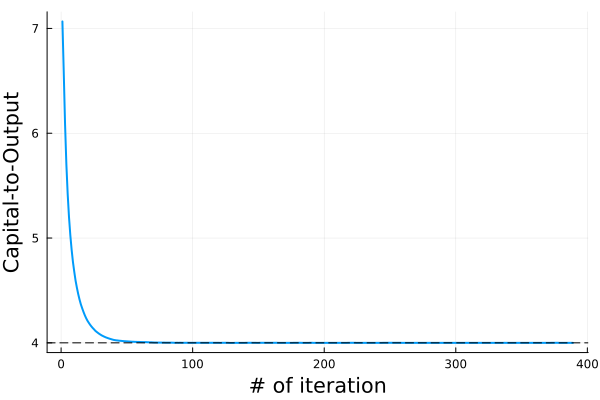

In [25]:
# plot convergence of targeted moment (K/Y)
using Plots
plot(1:iter-1, Model_KY[1:iter-1],
    xlabel="# of iteration",
    ylabel="Capital-to-Output",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([Targ_KY], lw=1, lc=:black, ls=:dash, label="")

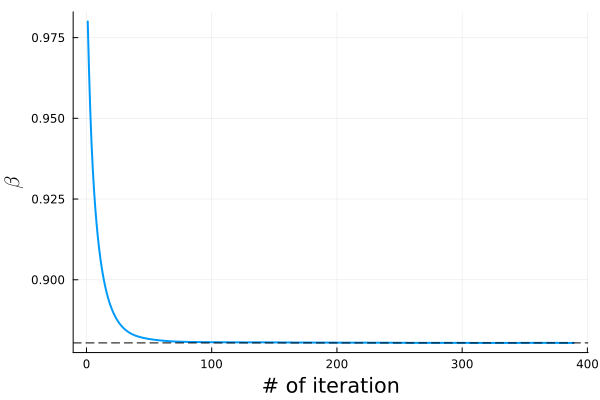

In [26]:
# Convergence of beta
using LaTeXStrings
plot(1:iter-1, β_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel=L"\beta",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([β], lw=1, lc=:black, ls=:dash, label="")

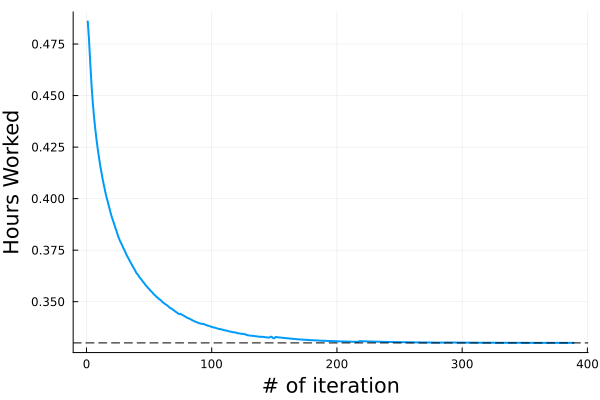

In [21]:
using Plots
plot(1:iter-1, Model_Work[1:iter-1],
    xlabel="# of iteration",
    ylabel="Hours Worked",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([Targ_Work], lw=1, lc=:black, ls=:dash, label="")

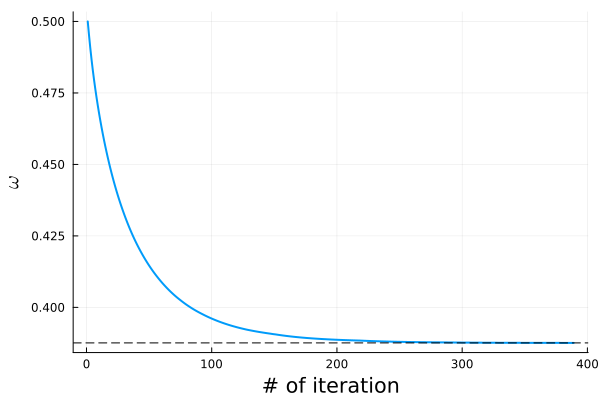

In [27]:
# Convergence of omega
using LaTeXStrings
plot(1:iter-1, ω_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel=L"\omega",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([ω], lw=1, lc=:black, ls=:dash, label="")

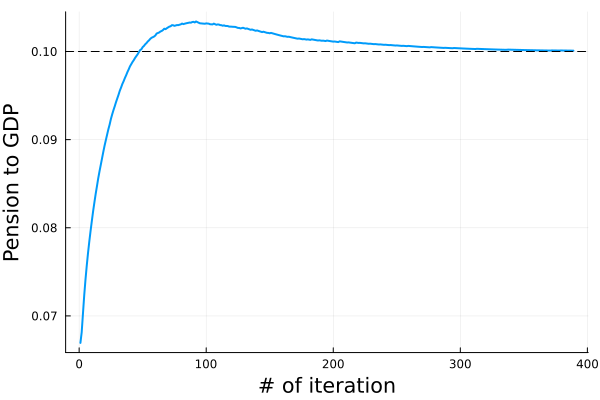

In [22]:
using Plots
plot(1:iter-1, Model_PY[1:iter-1],
    xlabel="# of iteration",
    ylabel="Pension to GDP",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([Targ_PY], lw=1, lc=:black, ls=:dash, label="")

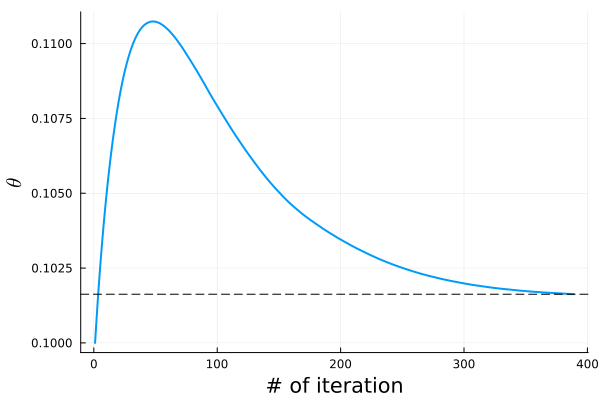

In [29]:
# Convergence of theta
using LaTeXStrings
plot(1:iter-1, θ_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel=L"\theta",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([θ], lw=1, lc=:black, ls=:dash, label="")